Starting training...
Epoch 100/5000 — Loss: 1.201978
Epoch 200/5000 — Loss: 0.857250
Epoch 300/5000 — Loss: 0.270737
Epoch 400/5000 — Loss: 0.344782
Epoch 500/5000 — Loss: 0.482459
Epoch 600/5000 — Loss: 0.071701
Epoch 700/5000 — Loss: 0.190154
Epoch 800/5000 — Loss: 0.418456
Epoch 900/5000 — Loss: 0.195943
Epoch 1000/5000 — Loss: -0.209920
Epoch 1100/5000 — Loss: 0.223499
Epoch 1200/5000 — Loss: -0.224032
Epoch 1300/5000 — Loss: -0.221766
Epoch 1400/5000 — Loss: 0.316196
Epoch 1500/5000 — Loss: 0.178825
Epoch 1600/5000 — Loss: 0.073344
Epoch 1700/5000 — Loss: 0.673477
Epoch 1800/5000 — Loss: -0.164364
Epoch 1900/5000 — Loss: -0.305383
Epoch 2000/5000 — Loss: 0.322245
Epoch 2100/5000 — Loss: -0.269115
Epoch 2200/5000 — Loss: -0.166314
Epoch 2300/5000 — Loss: 0.723244
Epoch 2400/5000 — Loss: 0.205054
Epoch 2500/5000 — Loss: 1.924791
Epoch 2600/5000 — Loss: -0.075076
Epoch 2700/5000 — Loss: 2.528448
Epoch 2800/5000 — Loss: 0.711955
Epoch 2900/5000 — Loss: 0.240269
Epoch 3000/5000 — Loss:

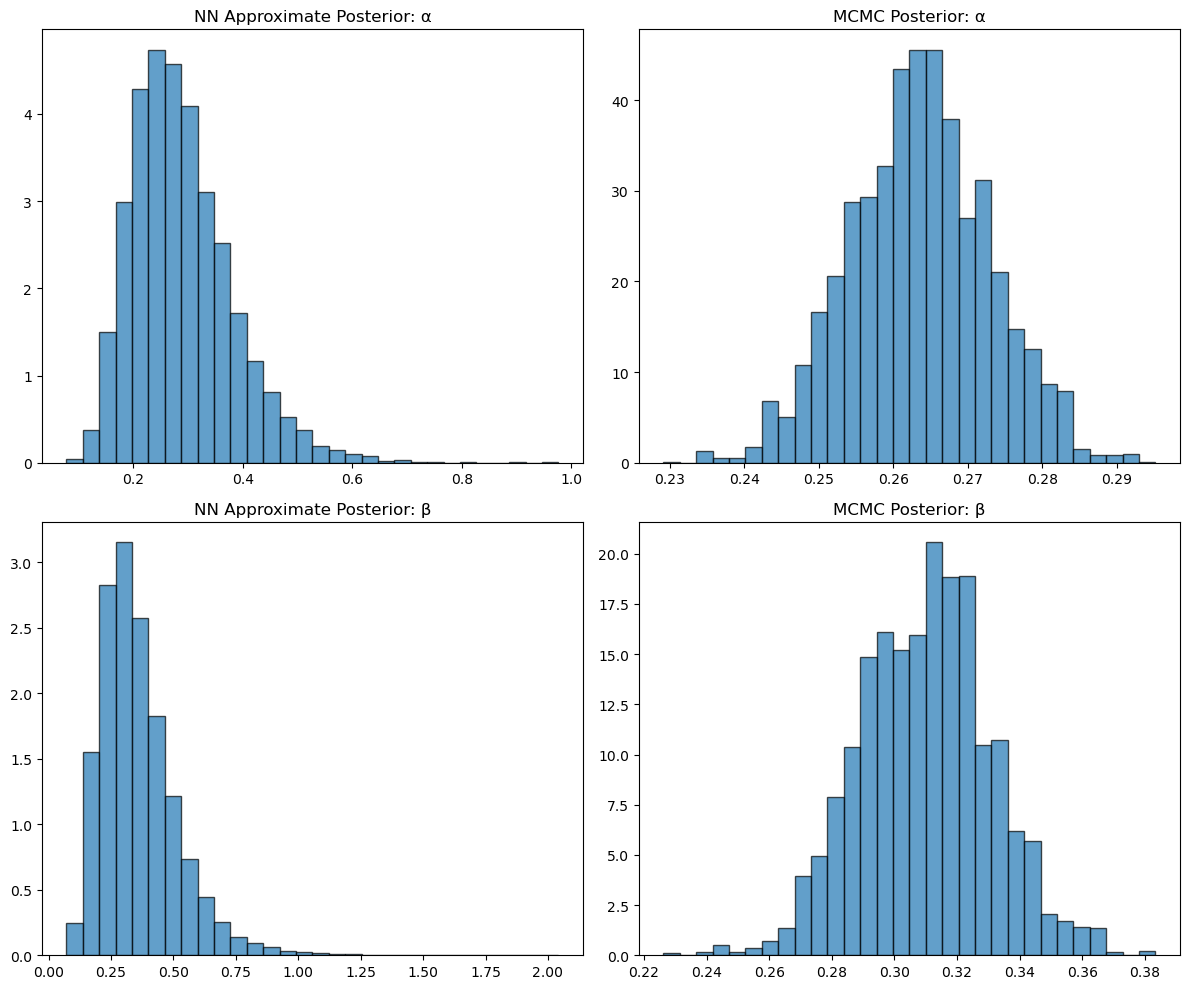

True parameters (α*, β*) = (0.2637, 0.2942)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Exponential, Gamma
import matplotlib.pyplot as plt
import math
import numpy as np

# 1. Define the GMM inference network (uses tanh‐bounded Cholesky + trace penalty)
class InferenceNetworkGMM(nn.Module):
    def __init__(self, num_components=3, input_dim=2, hidden_dim=128, cov_tanh_scaler=1.0):
        super().__init__()
        self.num_components = num_components
        self.input_dim = input_dim
        self.cov_tanh_scaler = cov_tanh_scaler  

        # Feature extractor: two-layer MLP with ReLU
        self.hidden_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True)
        )
        # Predict K * D component means
        self.mu_layer = nn.Linear(hidden_dim, num_components * input_dim)
        # Predict raw entries for the lower-triangular Cholesky factor
        self.cov_layer = nn.Linear(
            hidden_dim,
            num_components * (input_dim * (input_dim + 1) // 2)
        )
        # Predict unnormalized mixture logits
        self.weight_layer = nn.Linear(hidden_dim, num_components)

    def forward(self, stats):
        """
        stats: Tensor of shape (batch_size, input_dim) containing
               [log_mean, log_var] per example.
        Returns:
          mu:               (batch_size, num_components, input_dim)
          cov_matrices:     (batch_size, num_components, input_dim, input_dim)
          pi:               (batch_size, num_components)
          cov_trace_penalty: scalar regularization term
        """
        B = stats.size(0)
        h = self.hidden_layer(stats)  # (B, hidden_dim)

        # 1) Component means
        mu = self.mu_layer(h) \
               .view(B, self.num_components, self.input_dim)

        # 2) Raw Cholesky entries
        cov_raw = self.cov_layer(h) \
                  .view(B, self.num_components,
                        (self.input_dim * (self.input_dim + 1)) // 2)

        cov_matrices = []
        trace_list = []
        tril_idx = torch.tril_indices(self.input_dim, self.input_dim, device=stats.device)

        for k in range(self.num_components):
            # Build lower-triangular L for each component
            L = torch.zeros(B, self.input_dim, self.input_dim, device=stats.device)
            raw_vals = torch.tanh(cov_raw[:, k, :]) * self.cov_tanh_scaler
            L[:, tril_idx[0], tril_idx[1]] = raw_vals

            # Ensure positive diagonal via softplus + epsilon
            diag_idx = torch.arange(self.input_dim, device=stats.device)
            diag_vals = L[:, diag_idx, diag_idx]
            L[:, diag_idx, diag_idx] = torch.nn.functional.softplus(diag_vals) + 1e-3

            # Compute Σ_k = L L^T
            cov_k = L @ L.transpose(-1, -2)  # (B, D, D)

            # Collect trace for regularization
            trace_k = cov_k[:, 0, 0] + cov_k[:, 1, 1]
            trace_list.append(trace_k)

            # Add a tiny jitter proportional to trace to ensure PD
            jitter = (trace_k * 1e-6).unsqueeze(-1).unsqueeze(-1)
            cov_k = cov_k + torch.eye(self.input_dim, device=stats.device).unsqueeze(0) * jitter

            cov_matrices.append(cov_k)

        # Stack component covariances and compute trace penalty
        cov_matrices = torch.stack(cov_matrices, dim=1)  # (B, K, D, D)
        trace_all = torch.stack(trace_list, dim=1)       # (B, K)
        cov_trace_penalty = (trace_all ** 2).mean()

        # 3) Mixture weights via softmax
        logits = self.weight_layer(h)       # (B, K)
        pi = torch.softmax(logits, dim=1)   # (B, K)

        return mu, cov_matrices, pi, cov_trace_penalty


# 2. GMM negative log-likelihood loss with trace penalty
def gmm_nll_loss(mu, cov_matrices, pi, true_theta, trace_penalty, lambda_penalty=1e-3):
    """
    mu:           (B, K, D)
    cov_matrices: (B, K, D, D)
    pi:           (B, K)
    true_theta:   (B, D)
    """
    B, K, D = mu.size()
    # Safe log of mixture weights
    log_pi = torch.log(pi + 1e-12)  # (B, K)

    # Compute log-prob under each Gaussian component
    all_log_probs = []
    for k in range(K):
        mvn = MultivariateNormal(loc=mu[:, k, :],
                                 covariance_matrix=cov_matrices[:, k, :, :])
        all_log_probs.append(mvn.log_prob(true_theta))  # (B,)
    all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, K)

    # Combine with log-weights and marginalize via log-sum-exp
    log_joint = log_pi + all_log_probs                   # (B, K)
    log_p = torch.logsumexp(log_joint, dim=1)            # (B,)
    nll = -log_p.mean()                                  # scalar

    # Add trace regularization
    return nll + lambda_penalty * trace_penalty


# 3. Initialize weights with Kaiming uniform for ReLU layers
def initialize_weights(model):
    """
    Apply He (Kaiming) uniform initialization to all nn.Linear weights,
    and zero all biases.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)


# 4. Training loop on synthetic Gamma–Gamma data
def train_model(
    inference_net,
    optimizer,
    num_epochs=5000,
    batch_size=64,
    n_y_samples=1000,
    device='cpu'
):
    """
    Each epoch:
      1) Sample α, β ~ Exponential(1)
      2) Generate y ~ Gamma(α, β)
      3) Compute log-mean and log-variance of y
      4) Predict GMM posterior params
      5) Compute NLL + trace penalty
      6) Backpropagate & update
    """
    inference_net.train()
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()

        # 1) Draw true parameters from prior
        true_alpha = Exponential(1.0).sample((batch_size,)).to(device)
        true_beta = Exponential(1.0).sample((batch_size,)).to(device)

        # 2) Simulate y samples of shape (n_y_samples, batch_size)
        y_samples = Gamma(true_alpha.unsqueeze(1),
                          true_beta.unsqueeze(1))\
                    .sample((n_y_samples,))\
                    .squeeze(-1)

        # 3) Compute summary statistics and clamp them
        y_mean = y_samples.mean(dim=0)
        y_var = y_samples.var(dim=0)
        log_y_mean = torch.log(y_mean + 1e-6)
        log_y_var = torch.log(y_var + 1e-6)
        stats = torch.stack([log_y_mean, log_y_var], dim=1)  # (batch_size, 2)
        stats = torch.clamp(stats, min=-5.0, max=5.0)

        # 4) Forward pass
        pred_mu, pred_cov, pred_pi, trace_penalty = inference_net(stats)

        # 5) Prepare true latent (log α, log β)
        true_theta = torch.stack([
            torch.log(true_alpha + 1e-12),
            torch.log(true_beta + 1e-12)
        ], dim=1)  # (batch_size, 2)

        # 6) Compute loss and update
        loss = gmm_nll_loss(pred_mu, pred_cov, pred_pi,
                            true_theta, trace_penalty,
                            lambda_penalty=1e-3)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.6f}")


# 5. Metropolis–Hastings MCMC baseline in (log α, log β) space
def metropolis_hastings(
    y_samples,
    num_samples=10000,
    burn_in=2000,
    proposal_scale=0.1,
    device='cpu'
):
    """
    Sample from the true posterior p(log α, log β | y)
    using Metropolis–Hastings with Gaussian proposals.
    """
    y = y_samples.clone().detach().to(device)
    n = y.numel()
    sum_log_y = torch.sum(torch.log(y + 1e-12)).item()
    sum_y = torch.sum(y).item()

    def log_posterior(theta):
        log_a, log_b = theta[0], theta[1]
        a, b = log_a.exp(), log_b.exp()
        # Prior: α, β ~ Exp(1)
        lp = -a - b
        # Likelihood: Gamma(α, β)
        ll = (n * (a * log_b - torch.lgamma(a))
              + (a - 1) * sum_log_y
              - b * sum_y)
        return lp + ll

    # Initialize via method-of-moments
    y_np = y.cpu().numpy()
    mean_y, var_y = y_np.mean(), y_np.var()
    a0 = mean_y**2 / (var_y + 1e-6)
    b0 = mean_y / (var_y + 1e-6)
    theta = torch.tensor([math.log(max(a0, 1e-2)),
                          math.log(max(b0, 1e-2))],
                         device=device)
    logp_current = log_posterior(theta)

    samples = []
    for i in range(num_samples):
        proposal = theta + proposal_scale * torch.randn(2, device=device)
        logp_prop = log_posterior(proposal)
        if torch.log(torch.rand(1, device=device)) < (logp_prop - logp_current):
            theta, logp_current = proposal, logp_prop
        if i >= burn_in:
            samples.append(theta.cpu().numpy())
    return np.stack(samples, axis=0)


# 6. Test and plot comparison to MCMC
def test_and_plot(
    inference_net,
    n_y_samples=1000,
    mcmc_num_samples=15000,
    mcmc_burn_in=3000,
    device='cpu'
):
    """
    1) Sample one (α*, β*) and generate data y
    2) Compute stats and predict GMM posterior
    3) Draw samples from the GMM approximation
    4) Draw MCMC samples from the true posterior
    5) Plot histograms and save the figure
    """
    inference_net.eval()
    with torch.no_grad():
        # (A) True parameters from prior
        true_alpha = Exponential(1.0).sample((1,)).to(device)
        true_beta = Exponential(1.0).sample((1,)).to(device)

        # (B) Generate y observations
        y = Gamma(true_alpha, true_beta)\
            .sample((n_y_samples,)).squeeze(-1)

        # (C) Compute and clamp summary stats
        stats = torch.tensor([[
            torch.log(y.mean() + 1e-6).item(),
            torch.log(y.var()  + 1e-6).item()
        ]], device=device).clamp(-5.0, 5.0)

        # (D) Predict GMM posterior parameters
        pred_mu, pred_cov, pred_pi, _ = inference_net(stats)
        pred_mu, pred_cov, pred_pi = \
            pred_mu.squeeze(0).cpu(), pred_cov.squeeze(0).cpu(), pred_pi.squeeze(0).cpu()

        # (E) Sample 10,000 points from the GMM
        M = 10000
        comp_idx = torch.multinomial(pred_pi, M, replacement=True)
        pred = torch.zeros(M, 2)
        for k in range(pred_pi.size(0)):
            idx_k = (comp_idx == k).nonzero().squeeze(-1)
            if idx_k.numel() > 0:
                mvn = MultivariateNormal(pred_mu[k], covariance_matrix=pred_cov[k])
                pred[idx_k] = mvn.sample((idx_k.numel(),))
        pred = pred.numpy()
        pred_alpha = np.exp(np.clip(pred[:,0], -20, 20))
        pred_beta  = np.exp(np.clip(pred[:,1], -20, 20))

        # (F) Obtain MCMC baseline samples
        mh = metropolis_hastings(y, mcmc_num_samples, mcmc_burn_in, 0.2, device)
        mh_alpha = np.exp(np.clip(mh[:,0], -20, 20))
        mh_beta  = np.exp(np.clip(mh[:,1], -20, 20))

        # (G) Plot side-by-side histograms
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes[0,0].hist(pred_alpha, bins=30, density=True, alpha=0.7, edgecolor='black')
        axes[0,0].set_title('NN Approximate Posterior: α')
        axes[0,1].hist(mh_alpha,  bins=30, density=True, alpha=0.7, edgecolor='black')
        axes[0,1].set_title('MCMC Posterior: α')
        axes[1,0].hist(pred_beta,  bins=30, density=True, alpha=0.7, edgecolor='black')
        axes[1,0].set_title('NN Approximate Posterior: β')
        axes[1,1].hist(mh_beta,   bins=30, density=True, alpha=0.7, edgecolor='black')
        axes[1,1].set_title('MCMC Posterior: β')
        plt.tight_layout()
        plt.savefig('posterior_comparison.png', dpi=300)  
        plt.show()

        print(f"True parameters (α*, β*) = ({true_alpha.item():.4f}, {true_beta.item():.4f})")


# 7. Main script
if __name__ == "__main__":
    device = torch.device("cpu") 

    # Initialize network and weights
    inference_net = InferenceNetworkGMM(num_components=3,
                                        input_dim=2,
                                        hidden_dim=128,
                                        cov_tanh_scaler=1.0).to(device)
    initialize_weights(inference_net)

    # Set up optimizer
    optimizer = optim.Adam(inference_net.parameters(),
                           lr=5e-4,
                           weight_decay=1e-4)

    # Train
    print("Starting training...")
    train_model(inference_net, optimizer,
                num_epochs=5000,
                batch_size=64,
                n_y_samples=1000,
                device=device)
    print("Training complete.\n")

    # Test and plot
    test_and_plot(inference_net,
                  n_y_samples=1000,
                  mcmc_num_samples=15000,
                  mcmc_burn_in=3000,
                  device=device)
